## Problem Statement


FashionKart allows consumers to buy latest products from e-commerce platforms. Customers can leave reviews of products and experience to help other users make their purchase choices.
 
Given the dataset of product reviews and recommendation status, build a text classification model that can correctly identify the users who will recommend the product in the future. Also provide key topics/themes emerging from the customer reviews along with visualisation charts.

**Review:** Customer review for the product

**Recommendation:** Customer's recommendation for the product 

### Step 1 : Load required libraries 

In [2]:
#import the libraries
import numpy as np
import pandas as pd
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from nltk import sent_tokenize, word_tokenize
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
     
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abhinav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Step 2 : Load the input data 

In [3]:
#read the input data
input_data = pd.read_csv('dataset.csv')

In [4]:
#scan the dataframe
input_data.head()

,Review,Recommend
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [5]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Recommend  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [6]:
#convert the object datatype type to string
input_data['Review']=input_data['Review'].astype('str') 

In [7]:
#check the size of the dataframe
input_data.shape

(23486, 2)

In [8]:
#check the target class distribution in the dataset
input_data['Recommend'].value_counts()

Recommend
1    19314
0     4172
Name: count, dtype: int64

As we can see there are around 23K+ reviews in the dataset. Each review has a corresponding recommendation value and there are more recommended products compared to non-recommended

### Step 3 : Explore the data 

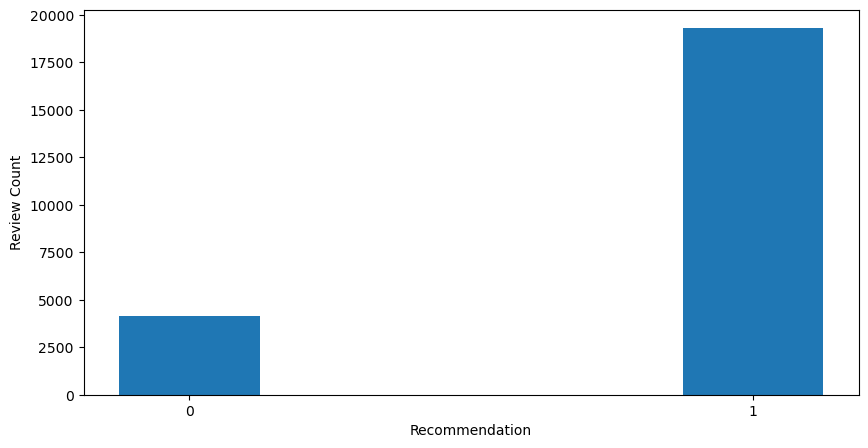

In [9]:
#check for the target class counts 
label_dist = input_data['Recommend'].value_counts().to_dict()
fig = plt.figure(figsize = (10, 5))
ax = plt.bar(label_dist.keys(), label_dist.values(), width=0.25)
plt.xticks([0,1])
plt.xlabel("Recommendation")
plt.ylabel("Review Count")
plt.show()

In [10]:
#check for any empty rows 
print(input_data.isnull().sum())

Review       0
Recommend    0
dtype: int64


In [11]:
len(input_data)

23486

In [12]:
#check for any duplicate reviews 
len(input_data['Review'])-len(input_data['Review'].drop_duplicates())

851

As we can observe there are 851 reviews which seem to be duplicate values. We will drop these from the dataframe.

In [13]:
#drop the repeated reviews 
input_data=input_data.drop_duplicates(subset='Review', keep="last")

In [14]:
len(input_data)

22635

We can now check the size of each review to establish if there is any relation between the recommendation and length of the reviews 

In [15]:
#check for the length of reviews 
input_data['length']=input_data['Review'].apply(lambda x: len(x.split(' ')))

In [16]:
#validate the newly added column in the dataframe 
input_data.sample(10)

,Review,Recommend,length
13087,I bought these in light grey and navy. they ar...,1,81
10232,"I love the long tunic with high slits, it's su...",1,92
1966,This skirt is beautiful...the color is definit...,1,84
22914,Wore this & got many compliments. true to size...,1,10
2668,I tried these shorts on in 5 colors and found ...,1,100
10855,This top was fun. casual with flair. it is a l...,1,58
1068,I loved this but hesitated to order since i'm ...,1,67
17518,"Admittedly, i ignored this dress on a few trip...",1,94
2223,Love this t-shirt! i live in miami and have a ...,1,40
14682,"I absolutely love this top! it is soft, comfor...",1,22


In [17]:
#avg. length for recommended and non recommended review 
print(round(input_data[input_data['Recommend']== 1 ]['length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['length'].mean()))

60
62


Seems like there isn't much of a difference between size of the customer review in the dataset 

### Step 4 : Data Preperation

Since the reviews are raw texts and contains multiple symbols, punctuations , hastags which might not be very useful for the modeling . 
We will use a helper function to clean the text and prepare it for modeling purpose.

In [18]:
# helper function to remove stopwords
input_data["Review_new"]=input_data["Review"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [19]:
#helper function for review cleaning 
def text_clean(review):
    #lowercase the review
    review=review.lower()
    #remove punctuation 
    review = re.sub('[()!?]', ' ', review)
    review = re.sub('\[.*?\]',' ', review)
    #remove non alphanumeric occurences
    review = re.sub("[^a-z0-9]"," ", review)
    #remove the @mention
    review = re.sub("@[A-Za-z0-9_]+","", review)
    #remove the hastags
    review = re.sub("#[A-Za-z0-9_]+","", review)
    #remove any links 
    review = re.sub(r"http\S+", "", review)
    review = re.sub(r"www.\S+", "", review)
    return review

In [20]:
#apply the function on the review column 
input_data['clean_review'] = input_data['Review_new'].apply(text_clean)

In [21]:
#validate if the reviews are clean
input_data[['Review','clean_review']].sample(10)

,Review,clean_review
12251,"I like the make of this dress, the fabric is t...",i like make dress fabric thick light time cu...
19224,Very pretty dress! wearing it for a family bea...,very pretty dress wearing family beach portra...
5791,I really loved the idea of this dress and thou...,i really loved idea dress thought may perfect ...
18920,This product is the best if not the most excel...,this product best excellent garment purchased ...
14543,I loved this top so much that i ended up purch...,i loved top much ended purchasing another colo...
20524,"I didn't know what to put for ""runs small, tru...",i know put runs small true size runs large ...
15204,I ordered the green and lilac. the pink color ...,i ordered green lilac pink color offered plac...
15137,As is true of a bunch of the fall clothing pho...,as true bunch fall clothing photos colors tot...
4548,The quality of this shirt is great and the col...,the quality shirt great colors pretty made lo...
5133,"What a dress! the print, the feel of the fabri...",what dress print feel fabric overall fit dr...


We can now observe that each review looks much cleaner and neat post the data cleansing prcoess 

In [22]:
# alculate updated length after removing the stopwords and cleaning review
input_data['new_length']=input_data['clean_review'].apply(lambda x: len(x.split(" ")))

In [23]:
#avg. length of the review for recommended and non-recommended labels 
print(round(input_data[input_data['Recommend']== 1]['new_length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['new_length'].mean()))

40
40


Post the data cleaning, the avg. length of the review becomes the same 

### Step 5 : Data split 

Now we split the 23K+ data into training and test dataset. One thing to note is to split the data based on target class to maintain the class balance

In [24]:
#Sentiment Classifier
#split the data into training and test set with balanced split based on target class
X_train, X_test, y_train, y_test = train_test_split(input_data["clean_review"],
                                                    input_data["Recommend"],test_size=0.3,
                                                    stratify=input_data['Recommend'])

In [25]:
#check the shape of train and test data 
print(X_train.shape[0],X_test.shape[0])

15844 6791


In [26]:
#check the class balance in train data 
print(y_train.value_counts())

Recommend
1    12974
0     2870
Name: count, dtype: int64


In [27]:
#check the target class balance in test data 
print(y_test.value_counts())

Recommend
1    5561
0    1230
Name: count, dtype: int64


### Step 6  : ML Modeling and Performance evaluation

After splitting the data , we move on to the modelling part. Given we are doing text classification, we will convert the text data using two approaches :
1. Count Vectoriser 
2. TF-IDF 

#### Using Count vectorizer

In [28]:
#Build a list of models to be trained and tested
modelclasses = [
    ("Logistic Regression", LogisticRegression),
    ("MNB", MultinomialNB),
    ("Random Forest", RandomForestClassifier)]

In [33]:
#Use the count vectoriser to convert the text data to numerical form
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create an empty list to log performance of the model based on score and auc
results = []

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    
    score = np.round(model.score(X_test_vec, y_test), 2)
    auc = np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]), 2)
    
    # Append the result to the list
    results.append({'modelname': modelname, 'score': score, 'auc': auc})

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Model performance
results_df

,modelname,score,auc
0,Logistic Regression,0.88,0.91
1,MNB,0.89,0.92
2,Random Forest,0.85,0.90


As we can observe , the Multinomial Naive Baysian performs the best out of all the models using count vectoriser 

#### Using TF-IDF

In [32]:
#Use the tf-idf vectoriser to convert the text data to numerical form
vectorizertfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizertfidf.fit_transform(X_train)
X_test_vec = vectorizertfidf.transform(X_test)

# Create an empty list to log performance of the model based on score and auc
results_tf = []

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    
    score = np.round(model.score(X_test_vec, y_test),2)
    auc=np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]),2)
    
    # Append the result to the list
    results_tf.append({'modelname': modelname, 'score': score, 'auc': auc})

# Convert the results list to a DataFrame
results_tf_df = pd.DataFrame(results_tf)  
   
#model comparison 
results_tf_df

,modelname,score,auc
0,Logistic Regression,0.88,0.93
1,MNB,0.82,0.90
2,Random Forest,0.85,0.91


Using the tf-idf vectoriser, we observe Logistic Regression outperforming the other models in terms of accuracy and auc.

## Step 7 : Topic Modeling 

In [34]:
#add additonal data clearning
def topic_clean(review):
        #remove numeric & special characters occurences
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = re.sub(r's+', ' ', review)
        return review

In [35]:
#apply the function on the review column 
input_data['clean_review'] = input_data['clean_review'].apply(topic_clean)

In [36]:
# Extract every unique term from the reviews 
review_terms = pd.Series(input_data['clean_review']).apply(lambda x: x.split())

In [37]:
# Create the disctioanry consisting index and unique term
dictionary = corpora.Dictionary(review_terms)

In [38]:
# Preapre the DTM(Document Term Matrix) from the term dictionary 
doc_term_matrix = [dictionary.doc2bow(rev) for rev in review_terms]

In [39]:
# Build the LDA model for topic extraction 
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10, 
                chunksize=500,
                passes=10)

In [40]:
#print the top 10 topics 
lda_model.print_topics()

[(0,
  '0.034*"color" + 0.034*"love" + 0.030*"great" + 0.026*"weater" + 0.024*"fit" + 0.020*"oft" + 0.018*"i" + 0.017*"top" + 0.017*"hirt" + 0.015*"nice"'),
 (1,
  '0.050*"top" + 0.041*"e" + 0.021*"hirt" + 0.020*"blou" + 0.018*"wear" + 0.018*"heer" + 0.017*"arm" + 0.017*"ee" + 0.016*"tank" + 0.015*"bra"'),
 (2,
  '0.049*"ize" + 0.031*"mall" + 0.025*"fit" + 0.025*"i" + 0.020*"u" + 0.018*"ordered" + 0.017*"t" + 0.017*"large" + 0.015*"x" + 0.015*"run"'),
 (3,
  '0.066*"t" + 0.042*"wai" + 0.034*"kirt" + 0.026*"fit" + 0.020*"length" + 0.012*"ize" + 0.011*"hort" + 0.011*"hip" + 0.011*"long" + 0.011*"hit"'),
 (4,
  '0.061*"de" + 0.042*"ign" + 0.040*"price" + 0.036*"di" + 0.018*"ale" + 0.017*"quality" + 0.014*"appointed" + 0.013*"worth" + 0.013*"it" + 0.012*"retailer"'),
 (5,
  '0.044*"t" + 0.037*"it" + 0.025*"i" + 0.021*"compliment" + 0.020*"love" + 0.019*"ab" + 0.018*"uit" + 0.018*"olutely" + 0.016*"many" + 0.016*"wore"'),
 (6,
  '0.032*"like" + 0.029*"look" + 0.024*"dre" + 0.019*"fabric" + 

#### Topic Visualization 

In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)     
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.140788 -0.017264       1        1  21.276368
6      0.144843  0.039557       2        1  18.151574
0      0.113673  0.119427       3        1  14.076677
8      0.117273 -0.010118       4        1  11.102919
3      0.101725  0.069871       5        1   9.914194
1      0.031773  0.144965       6        1   6.789180
5     -0.021352 -0.229797       7        1   6.311548
4     -0.077647 -0.316575       8        1   5.073284
7     -0.104601  0.094702       9        1   4.790537
9     -0.446475  0.105232      10        1   2.513719, topic_info=         Term          Freq         Total Category  logprob  loglift
9         dre  13488.000000  13488.000000  Default  30.0000  30.0000
192         o   3892.000000   3892.000000  Default  29.0000  29.0000
171        al   2812.000000   2812.000000  Default  28.0000  28.0000
162         t  12231.000000  12231.000000  Default  27.0000  27.0000
50        ize   9701.000000   9701.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
466      hort    339.994845   2392.554229  Topic10  -4.0133   1.7322
115      long    339.187190   2453.386950  Topic10  -4.0156   1.7047
439    button    214.191689    956.228623  Topic10  -4.4753   2.1873
52         ly    102.852941    280.125364  Topic10  -5.2089   2.6815
437  pictured     93.682244    470.619897  Topic10  -5.3023   2.0693

[635 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         7  0.998834     ab
1357      8  0.993290    ack
87        5  0.995800   adju
416       2  0.997248   adly
2168      4  0.990227  adore
...     ...       ...    ...
1162      4  0.144177     ye
1162      6  0.124769     ye
1162      8  0.729204     ye
237       4  0.726977   year
237       9  0.272440   year

[1127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 1, 9, 4, 2, 6, 5, 8, 10])